This notebook contain the flow of using pre-trained VGG16 model for the image classification.

Experiment configuration:


1.   Added custom dense layer to accommodate number of classes (3)
2.   Enabled last 3 layers to learning



In [ ]:
!pip install boto3==1.34.31
!pip install livelossplot

In [4]:
import os
import boto3
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

### Download data from S3 bucket

In [5]:
AWS_ACCESS_KEY_ID = "XXXXXXXXXXX"
AWS_SECRET_ACCESS_KEY = "XXXXXXXXXXXXXXXXXXXXXXXX"
AWS_REGION = "XXXXXXXXXXXXXXXXXXXXXX"

In [7]:
s3 = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)

In [8]:
bucket_name = "my-image-classification"
file_key = "split_dataset_3.zip"
download_path = os.getcwd()
s3.download_file(bucket_name, file_key, os.path.join(download_path, "downloaded_data.zip"))

In [ ]:
!unzip downloaded_data.zip

In [10]:
data_path = os.path.join(download_path, 'split_dataset_3')

In [ ]:
# data_path = "/content/drive/MyDrive/ml_data/Hawells Image Classificatio/split_dataset_3"

In [26]:
# Constants

img_height = 224
img_width = 224

num_classes = 3
batch_size = 32

num_epochs = 100

In [27]:
## Data Preparation

# Assuming you have your images organized in separate folders for each class


scale_datagen = ImageDataGenerator(rescale=1./255)

aug_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to 0-1
    rotation_range=40,  # Rotate images randomly by up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20%
    height_shift_range=0.2,  # Shift images vertically by up to 20%
    shear_range=0.2,  # Shear images randomly
    zoom_range=0.2,  # Zoom images randomly
    horizontal_flip=True,  # Flip images horizontally randomly
    fill_mode='nearest')  # Fill empty pixels with nearest neighbor interpolation


train_generator = aug_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

test_generator = aug_datagen.flow_from_directory(
    os.path.join(data_path, "test"),
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

val_generator = aug_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

label_map = (test_generator.class_indices)
class_map = dict((v,k) for k, v in label_map.items())

Found 1449 images belonging to 3 classes.
Found 183 images belonging to 3 classes.
Found 181 images belonging to 3 classes.


In [28]:
class_map

{0: 'human', 1: 'no_human', 2: 'uber_eats'}

In [29]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [63]:
input_shape = (img_height, img_width, 3)
optim_1 = Adam(learning_rate=0.001)

n_steps = train_generator.samples // batch_size
n_val_steps = val_generator.samples // batch_size
n_epochs = 100

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, num_classes, optim_1, fine_tune=3)

In [64]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

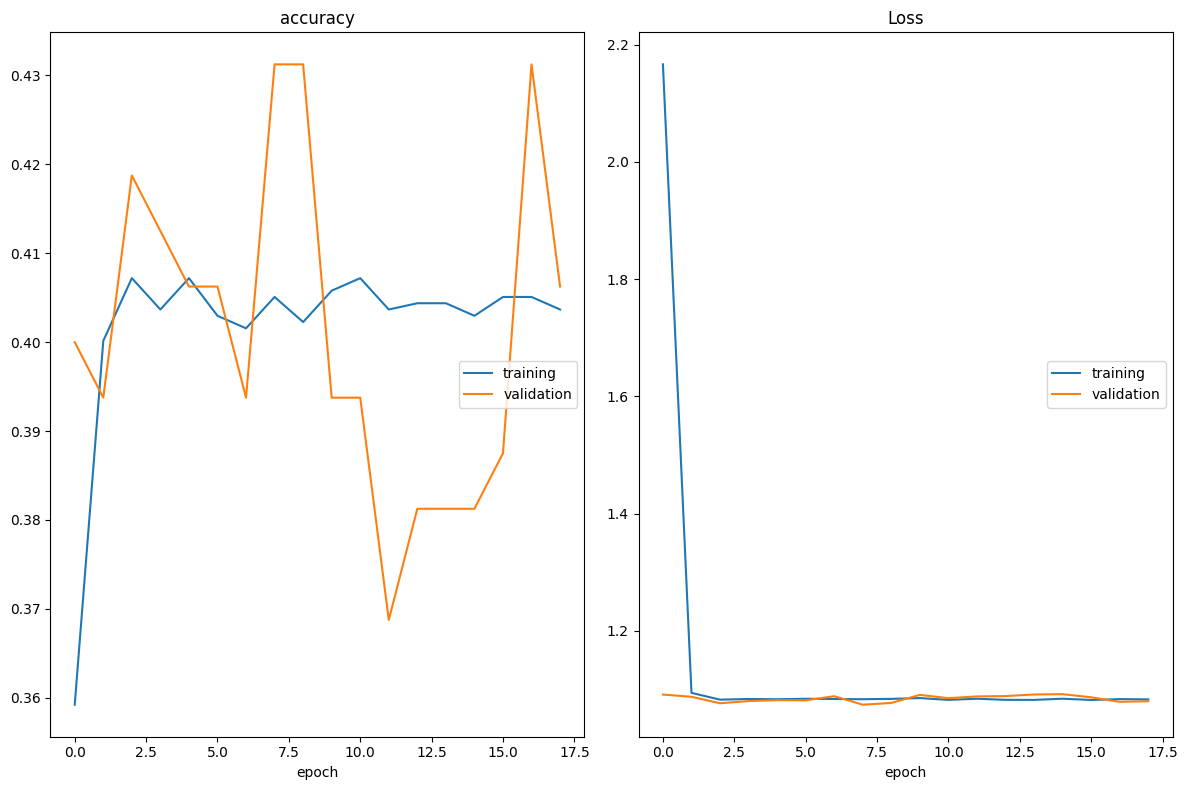

accuracy
	training         	 (min:    0.359, max:    0.407, cur:    0.404)
	validation       	 (min:    0.369, max:    0.431, cur:    0.406)
Loss
	training         	 (min:    1.082, max:    2.166, cur:    1.083)
	validation       	 (min:    1.074, max:    1.092, cur:    1.080)
45/45 [==============================] - 26s 585ms/step - loss: 1.0832 - accuracy: 0.4037 - val_loss: 1.0800 - val_accuracy: 0.4062


In [65]:
vgg_history = vgg_model.fit(train_generator,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_data=val_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [49]:
# Upload model to S3
s3.upload_file('tl_model_v1.weights.best.hdf5', bucket_name, os.path.join("models", "tl_4_model_v1.weights.best.hdf5"))
print("File uploaded successfully!")

File uploaded successfully!


In [50]:
import shutil

In [51]:
model_path = "/content/drive/MyDrive/ml_data/Hawells Image Classificatio/model"

In [56]:
shutil.copy('tl_model_v1.weights.best.hdf5', os.path.join(model_path, 'tl_4_model_v1.weights.best.hdf5'))

'/content/drive/MyDrive/ml_data/Hawells Image Classificatio/model/tl_3_model_v1.weights.best.hdf5'

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from keras.models import load_model

In [67]:
def get_report():
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
    model = load_model('tl_model_v1.weights.best.hdf5')
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    report1 = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
    report2 = classification_report(true_classes, predicted_classes, target_names=class_labels)

    print(report2)

In [68]:
get_report()

6/6 [==============================] - 3s 403ms/step
              precision    recall  f1-score   support

       human       0.00      0.00      0.00        62
    no_human       0.00      0.00      0.00        47
   uber_eats       0.40      1.00      0.58        74

    accuracy                           0.40       183
   macro avg       0.13      0.33      0.19       183
weighted avg       0.16      0.40      0.23       183



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
def predict_class(model, image_path):
    # Load the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)

    # Preprocess the image
    img_batch = np.expand_dims(img_array, axis=0)
    img_batch = img_batch / 255.0  # Normalize to [0, 1] range

    # Make predictions
    predictions = model.predict(img_batch, verbose=0)[0]

    pred_class = predictions.argmax()
    pred_prob = predictions[pred_class]

    pred_label = class_map[pred_class]

    return pred_label, pred_prob


In [ ]:
model = load_model('tl_model_v1.weights.best.hdf5')

In [ ]:
test_data_path = os.path.join(data_path, "test")
image_path = os.path.join(test_data_path, "human", "61.png")
predict_class(model, image_path)

('human', 0.99598986)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for cls in os.listdir(test_data_path):
  if not cls.startswith('.'):
    images = os.listdir(os.path.join(test_data_path, cls))
    for img in images:
      image_path = os.path.join(test_data_path, cls, img)
      pred_cls, pred_prob = predict_class(model, image_path)
      if pred_cls != cls:
        print(f"image: {img}, actual : {cls}, predicted : {pred_cls}, prob : {pred_prob}")

image: 287.png, actual : human, predicted : no_human, prob : 0.9687432050704956
image: 342.png, actual : human, predicted : no_human, prob : 0.8450161218643188
image: 309.png, actual : human, predicted : no_human, prob : 0.6755945086479187
image: 197.png, actual : human, predicted : no_human, prob : 0.8086998462677002
image: 405.png, actual : human, predicted : no_human, prob : 0.8385722637176514
image: 497.png, actual : human, predicted : uber_eats, prob : 0.7559285163879395
image: 522.png, actual : human, predicted : no_human, prob : 0.8554825782775879
image: 148.png, actual : no_human, predicted : human, prob : 0.5573235154151917
image: 128.png, actual : no_human, predicted : human, prob : 0.7180339694023132
image: 284.png, actual : no_human, predicted : human, prob : 0.6750060319900513
image: 275.png, actual : no_human, predicted : human, prob : 0.7030084729194641
image: 212.png, actual : no_human, predicted : human, prob : 0.5449180603027344
image: 119.png, actual : no_human, pred